In [20]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
from haloflow import data as D
from haloflow import util as U

In [21]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [22]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

## read $q_\phi(Y\,|\,X)$

In [23]:
qphis = U.read_best_ndes('h2.v1.Simba100.mags', n_ensemble=5, device=device, 
                         dat_dir='../../data/hf2/dann/npe/', verbose=True)
Y_test, X_test = D.hf2_centrals('test', 'mags', sim='Simba100')

1005 models trained
[594, 316, 732, 978, 915]


## some examples

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:00<00:00, 64352.02it/s]


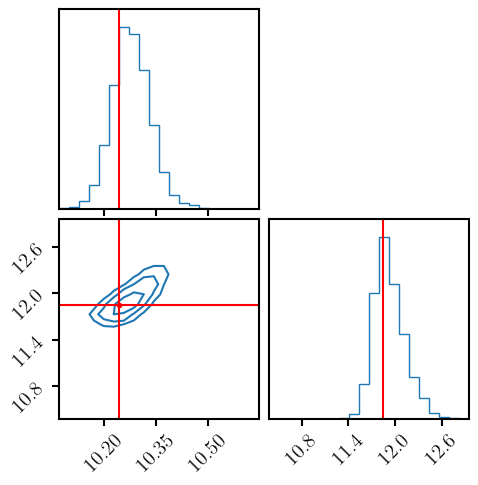

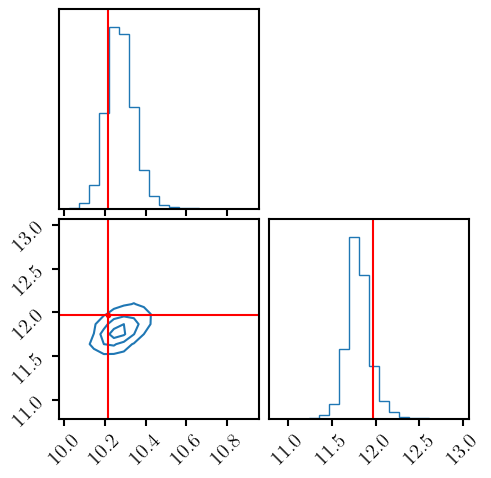

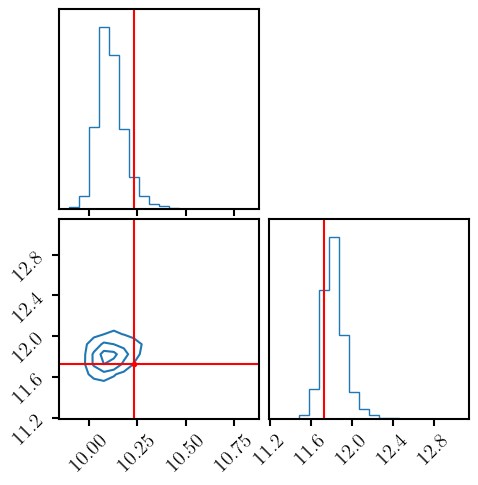

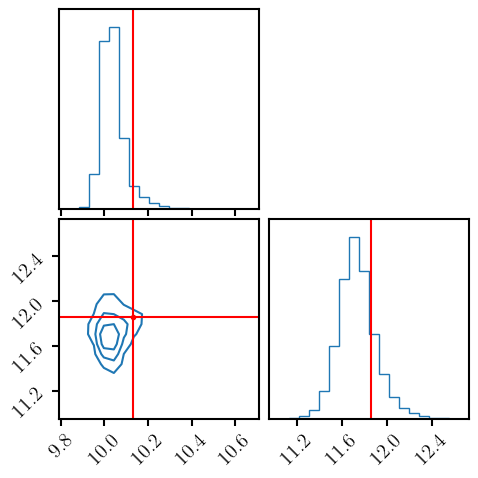

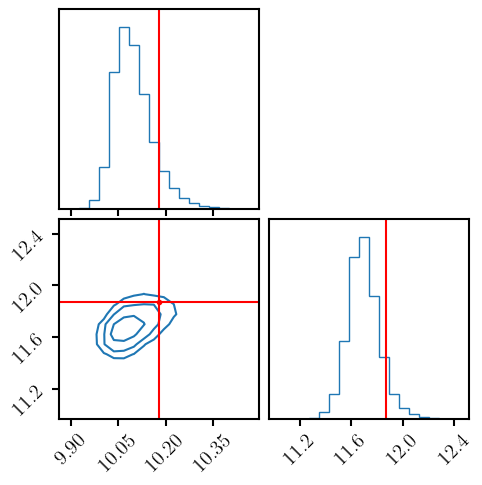

In [25]:
n_sample = 10_000
for i in np.random.choice(np.arange(X_test.shape[0]), size=5, replace=False): 
    y_samp = []
    for qphi in qphis: 
        _samp = qphi.sample((int(n_sample/len(qphis)),),
                               x=torch.tensor(X_test[i], dtype=torch.float32).to(device), 
                               show_progress_bars=True)
        y_samp.append(_samp.detach().cpu().numpy())
    y_nde = np.concatenate(np.array(y_samp), axis=0)
    
    
    fig = DFM.corner(y_nde, color='C0', plot_datapoints=False, plot_density=False)
    DFM.overplot_points(fig, [Y_test[i]], color='r')
    DFM.overplot_lines(fig, Y_test[i], color='r')

## coverage test

In [26]:
n_sample = 1000

ranks = []
y_nde = [] 
for i in range(X_test.shape[0]): 
    y_samp = []
    for qphi in qphis: 
        _samp = qphi.sample((int(n_sample/len(qphis)),),
                               x=torch.tensor(X_test[i], dtype=torch.float32).to(device), 
                               show_progress_bars=False)
        y_samp.append(_samp.detach().cpu().numpy())
    y_nde.append(np.concatenate(np.array(y_samp), axis=0)) 
    
    _ranks = []
    for i_dim in range(y_nde[-1].shape[1]): 
        _ranks.append(np.mean(y_nde[-1][:,i_dim].flatten() < Y_test[i, i_dim]))
    ranks.append(_ranks)
    
ranks = np.array(ranks)
y_nde = np.array(y_nde)

[]

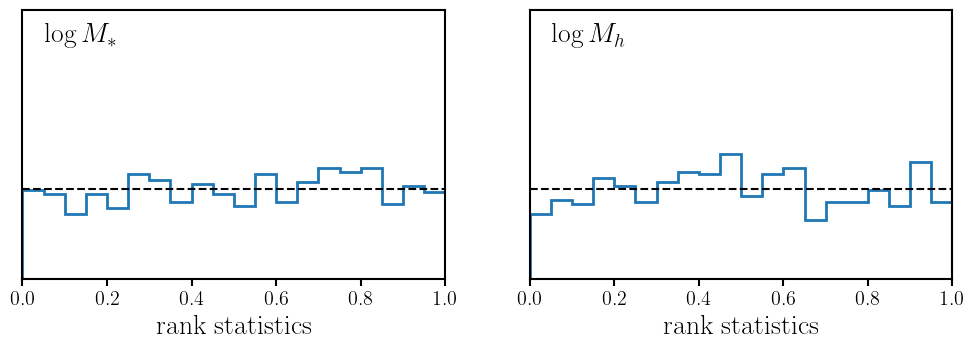

In [27]:
fig = plt.figure(figsize=(12,3.5))
sub = fig.add_subplot(121)

_ = sub.hist(ranks[:,0], range=(0., 1), bins=20, histtype='step', density=True, linewidth=2)

sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.text(0.05, 0.95, r'$\log M_*$', fontsize=20, transform=sub.transAxes, ha='left', va='top')
sub.set_xlabel('rank statistics', fontsize=20)
sub.set_xlim(0., 1.)
sub.set_ylim(0., 3.)
sub.set_yticks([])

sub = fig.add_subplot(122)

_ = sub.hist(ranks[:,1], range=(0., 1), bins=20, histtype='step', density=True, linewidth=2)

sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.text(0.05, 0.95, r'$\log M_h$', fontsize=20, transform=sub.transAxes, ha='left', va='top')
sub.set_xlabel('rank statistics', fontsize=20)
sub.set_xlim(0., 1.)
sub.set_ylim(0., 3.)
sub.set_yticks([])

In [28]:
from tarp import get_drp_coverage

In [29]:
alpha, ecp = get_drp_coverage(np.swapaxes(y_nde, 0, 1), Y_test, references="random", metric="euclidean")


/var/folders/1g/jdg8wj2j06g8cm00gnn6zvzc0000gn/T/ipykernel_30360/1933113637.py:1: DeprecatedWarning: get_drp_coverage is deprecated as of 0.1.0 and will be removed in 0.2.0. Use get_tarp_coverage instead
  alpha, ecp = get_drp_coverage(np.swapaxes(y_nde, 0, 1), Y_test, references="random", metric="euclidean")


/var/folders/1g/jdg8wj2j06g8cm00gnn6zvzc0000gn/T/ipykernel_30360/3997761372.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', fontsize=15)


(0.0, 1.0)

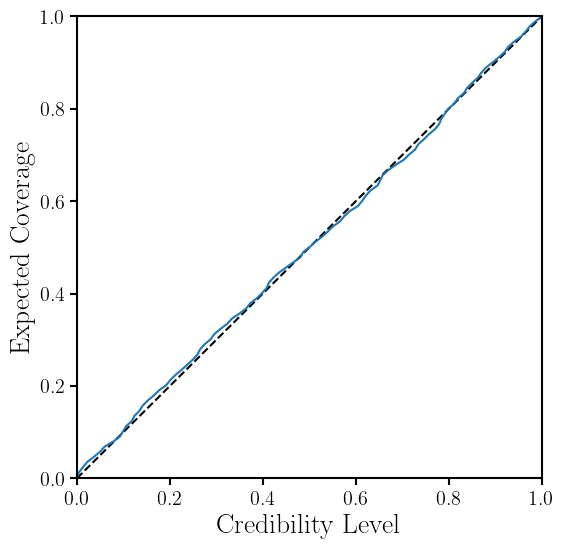

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], ls="--", color="k")
ax.plot(alpha, ecp, c='C0')
ax.legend(loc='lower right', fontsize=15)
ax.set_ylabel("Expected Coverage", fontsize=20)
ax.set_ylim(0., 1.)
ax.set_xlabel("Credibility Level", fontsize=20)
ax.set_xlim(0., 1.)